In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random
import itertools
from scipy.optimize import minimize, least_squares
from scipy.optimize import NonlinearConstraint
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import ConvexHull
from scipy.stats import zscore
from itertools import permutations, product
from scipy.stats import gmean, gstd

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 18
mpl.rcParams['mathtext.fontset'] = 'cm'

In [6]:
import matplotlib.colors as colors
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
import matplotlib as mpl

# Models

## Heterotrophy

Set of metabolites are:
<ul>
    <li> Corg
    <li> NAD
    <li> NADH
    <li> O2
    <li> ATP
    <li> ADP
    <li> CO2
    <li> biomass
</ul>

Set of parameters are:

<ul>
    <li> $\nu_{supply}$
    <li> $\gamma$'s
    <li> $\phi$'s
    <li> total ATP/ADP and NADH/NAD+ pools
</ul>

In [7]:
eps = 1e-10 # eps is a small number that prevents runaway extinctions
tau = 1e-3  # tau promotes numerical stability by nondimensionalizing the equations

In [8]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    x[x>1e8] = 1e8
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = Corg * (NAD ** 2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * O2 * phi_resp * gamma_resp_inv * tau
    nu_ana = Corg * (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    mu = nu_ana.copy()
    
    dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    # dNADH = 2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - mu * ATP
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Simulations

## Parameters

### Hyperparameters, which we fix over all simulations

In [9]:
nu_supply = 2.
O20 = 1e3
Corg0 = 1e3

### Mean parameter estimates, obtained from data

In [10]:
# gammas are in (g s)/(mol) units.
mean_gamma_cat_inv = 200
mean_gamma_resp_inv = 40
mean_gamma_ana_inv = 200

mean_S4 = 4.0
mean_S3 = 0.3
mean_S5 = 1.1

# KM is in uM
mean_KM = 100
mean_r1 = 10.
mean_r2 = 0.1

These ones represent initial conditions.

In [11]:
# micromolar concentrations
NADH0 = 1e3
ATP0 = 1e3

In [12]:
def give_initial_condns(NADH0, ATP0, KM):
    # nondimensionalized concentrations
    NADH0 /= KM
    ATP0 /= KM

    return Corg0, NADH0, O20, ATP0

### Geometric standard deviations ($k$-fold variation) 

In [13]:
# gammas are in (g s)/(mol) units.
del_gamma_cat_inv = 1.
del_gamma_resp_inv = 1.
del_gamma_ana_inv = 1.

del_S4 = 1.
del_S3 = 1.
del_S5 = 1.

# KM is in uM
del_KM = 1.
del_r1 = 1.
del_r2 = 1.

### Sampling parameters

Note that this sampling is not uniform since we sample all parameters in an uncorrelated fashion.
Thus, the resulting joint distribution is biased to towards the joint mean of all parameters.
It is much more unlikely for all parameters to simultaneously assume values much larger than their mean.

In [14]:
def sample_params():
    '''
    Samples parameters lognormally from a predefined set of ranges defined above.
    Outputs those parameters in a specific order.
    '''
    gamma_cat_inv = np.random.lognormal(np.log(mean_gamma_cat_inv), np.log(del_gamma_cat_inv))
    gamma_resp_inv = np.random.lognormal(np.log(mean_gamma_resp_inv), np.log(del_gamma_resp_inv))
    gamma_ana_inv = np.random.lognormal(np.log(mean_gamma_ana_inv), np.log(del_gamma_ana_inv))

    S4 = np.random.lognormal(np.log(mean_S4), np.log(del_S4))
    S3 = np.random.lognormal(np.log(mean_S3), np.log(del_S3))
    S5 = np.random.lognormal(np.log(mean_S5), np.log(del_S5))

    # KM is in uM
    KM = np.random.lognormal(np.log(mean_KM), np.log(del_KM))
    r1 = np.random.lognormal(np.log(mean_r1), np.log(del_r1))
    r2 = np.random.lognormal(np.log(mean_r2), np.log(del_r2))

    return gamma_cat_inv, gamma_resp_inv, gamma_ana_inv, S4, S3, S5, KM, r1, r2

To sample uniformly from the joint distribution, one needs to be smarter. There are methods, but we need to know if this sampling is necessary.

### Dynamics

In [15]:
gamma_cat_inv, gamma_resp_inv, gamma_ana_inv, S4, S3, S5, KM, r1, r2 = sample_params()

In [16]:
phi_cat = 0.5
phi_ana = 0.4
phi_resp = 0.1

In [17]:
y0 = np.array(give_initial_condns(NADH0, ATP0, KM))
NUM_METS = len(y0)
S6 = 0.2

# Evaluation time
TFINAL = 1e2
t = np.logspace(-4, 2, 1000 )

In [18]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

### Plot

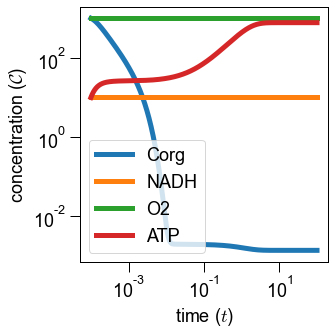

In [32]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

### Fluxes

In [33]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = Corg * (NAD ** 2) * phi_cat * gamma_cat_inv * tau
    nu_resp = (NADH ** 2) * O2 * phi_resp * gamma_resp_inv * tau
    nu_ana = Corg * (NADH ** S6) * (ATP ** S5) * phi_ana * gamma_ana_inv * tau
    
    return np.array([nu_cat, nu_resp, nu_ana])

In [34]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

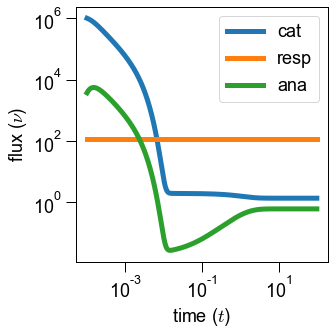

In [35]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(3):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=5 )
ax.legend([ 'cat', 'resp', 'ana' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

# Sweeping over $\phi_{ana}$

In [36]:
mus = []
phianas = []

phi_cat = 0.5
phi_resp = 0.03

gamma_cat_inv, gamma_resp_inv, gamma_ana_inv, S4, S3, S5, KM, r1, r2 = sample_params()
y0 = np.array(give_initial_condns(NADH0, ATP0, KM))

for t_phi_ana in np.linspace(0.01, 1-phi_cat-phi_resp, 100):
    phi_ana = t_phi_ana.copy()

    NUM_METS = len(y0)

    # Evaluation time
    TFINAL = 1e2
    t = np.logspace(-4, 2, 1000 )
    S6 = 0.4

    y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

    mus.append(nus[-1, -1])
    phianas.append(t_phi_ana)

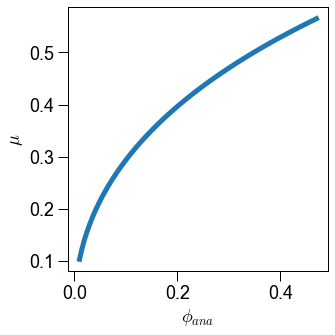

In [37]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( r'$\mu$' )
ax.set_xlabel( r'$\phi_{ana}$' )
ax.plot( phianas, mus, lw=5 )
# ax.set_yscale('log')
# ax.set_xscale('log')

fig.tight_layout()
plt.show()

# Sweeping over $S_6$

In [38]:
phi_cat = 0.5
phi_resp = 0.03


In [39]:
mus = []
zcs = []

phi_ana = 1-phi_cat-phi_resp
gamma_cat_inv, gamma_resp_inv, gamma_ana_inv, S4, S3, S5, KM, r1, r2 = sample_params()
y0 = np.array(give_initial_condns(NADH0, ATP0, KM))

for S6 in np.linspace(-0.1, 0.5, 100):
    NUM_METS = len(y0)

    # Evaluation time
    TFINAL = 1e2
    t = np.logspace(-4, 2, 1000 )

    y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

    mus.append(nus[-1, -1])
    zcs.append(S6)

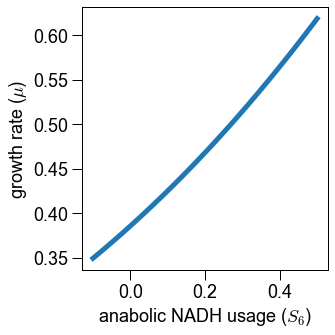

In [40]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( 'growth rate (' + r'$\mu$' + ')' )
ax.set_xlabel( 'anabolic NADH usage (' + r'$S_6$' + ')' )
ax.plot( zcs, mus, lw=5 )
# ax.set_yscale('losg')
# ax.set_xscale('log')

fig.tight_layout()
plt.show()

In [41]:
mus[-1] - mus[0]

0.2696864107752093

# Bootstrapping and computing $\Delta \mu$

### Changing only $\gamma$'s

In [44]:
# gammas are in (g s)/(mol) units.
del_gamma_cat_inv = 3.
del_gamma_resp_inv = 3.
del_gamma_ana_inv = 3.

del_S4 = 1.
del_S3 = 1.
del_S5 = 1.

# KM is in uM
del_KM = 1.
del_r1 = 1.
del_r2 = 1.

In [45]:
BOOT = 500
delmus = []

for _ in tqdm(range(BOOT)):
    mus = []
    zcs = []

    phi_ana = 1-phi_cat-phi_resp
    gamma_cat_inv, gamma_resp_inv, gamma_ana_inv, S4, S3, S5, KM, r1, r2 = sample_params()
    y0 = np.array(give_initial_condns(NADH0, ATP0, KM))

    for S6 in np.linspace(-0.1, 0.5, 100):
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e2
        t = np.logspace(-4, 2, 1000 )

        y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


        nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

        mus.append(nus[-1, -1])
        zcs.append(S6)

    delmus.append(mus[-1] - mus[0])

100%|██████████| 500/500 [13:57<00:00,  1.67s/it]


(array([ 9.,  9., 23., 19., 17., 17., 34., 38., 27., 24., 22., 34., 38.,
        26., 14., 20., 20., 25., 31., 53.]),
 array([0.02071753, 0.04228848, 0.06385942, 0.08543037, 0.10700132,
        0.12857226, 0.15014321, 0.17171415, 0.1932851 , 0.21485605,
        0.23642699, 0.25799794, 0.27956889, 0.30113983, 0.32271078,
        0.34428172, 0.36585267, 0.38742362, 0.40899456, 0.43056551,
        0.45213646]),
 <BarContainer object of 20 artists>)

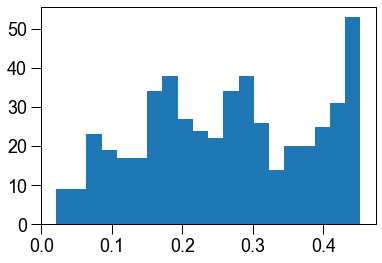

In [46]:
plt.hist(delmus, bins=20)

In [47]:
np.mean(delmus)

0.2636326276946505

### Changing only $S_x$'s

In [48]:
# gammas are in (g s)/(mol) units.
del_gamma_cat_inv = 1.
del_gamma_resp_inv = 1.
del_gamma_ana_inv = 1.

del_S4 = 2.
del_S3 = 2.
del_S5 = 2.

# KM is in uM
del_KM = 1.
del_r1 = 1.
del_r2 = 1.

In [49]:
import signal

# Function to handle the alarm signal
def handler(signum, frame):
    raise TimeoutError()

# Set the signal handler
signal.signal(signal.SIGALRM, handler)

BOOT = 500
delmus = []

for _ in tqdm(range(BOOT)):
    mus = []
    zcs = []

    phi_ana = 1-phi_cat-phi_resp
    gamma_cat_inv, gamma_resp_inv, gamma_ana_inv, S4, S3, S5, KM, r1, r2 = sample_params()
    y0 = np.array(give_initial_condns(NADH0, ATP0, KM))

    erred = 0
    for S6 in np.linspace(-0.1, 0.5, 100):
        if erred:
            break
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e2
        t = np.logspace(-4, 2, 1000 )

        try:
            # Set an alarm for some number of seconds in the future
            signal.alarm(10)  # 10 seconds, adjust this as needed

            y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau', max_step=1.0 ).y
            nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

            # If we've gotten this far without an exception, cancel the alarm
            signal.alarm(0)

            mus.append(nus[-1, -1])
            zcs.append(S6)
        except TimeoutError:
            print(f"Timeout occurred while solving the model for S3={S3}, S4={S4}, S5={S5}")
            erred=1
            continue
        except Exception as e:
            print(f"An error occurred while solving the model for S3={S3}, S4={S4}, S5={S5}: {e}")
            continue

    if len(mus) > 1:
        delmus.append(mus[-1] - mus[0])


  4%|▍         | 22/500 [01:32<45:51,  5.76s/it]

Timeout occurred while solving the model for S3=0.42859752537106993, S4=10.491089150947337, S5=11.892081448822065


  7%|▋         | 34/500 [02:35<1:02:39,  8.07s/it]

Timeout occurred while solving the model for S3=0.1822345782998992, S4=4.273817152809312, S5=3.848762933581592


 14%|█▍        | 72/500 [05:26<44:52,  6.29s/it]  

Timeout occurred while solving the model for S3=0.8026031241393563, S4=21.87298906274307, S5=3.903354213049773


 16%|█▌        | 80/500 [06:02<40:36,  5.80s/it]

Timeout occurred while solving the model for S3=0.5934206439172466, S4=2.322949775708627, S5=6.367771097507674


 16%|█▋        | 82/500 [06:19<51:18,  7.37s/it]

Timeout occurred while solving the model for S3=0.6402323299664253, S4=3.5644505575856553, S5=4.437971286139156


 18%|█▊        | 88/500 [06:51<44:14,  6.44s/it]

Timeout occurred while solving the model for S3=0.18073496316657653, S4=6.4618679420237894, S5=3.98365574069574


 30%|███       | 150/500 [11:31<49:10,  8.43s/it]

Timeout occurred while solving the model for S3=0.33728915290376754, S4=3.739369677816395, S5=4.233118063677121


 37%|███▋      | 185/500 [14:00<29:41,  5.66s/it]

Timeout occurred while solving the model for S3=0.08951938230083144, S4=16.30497252682874, S5=5.467698593421277


 38%|███▊      | 189/500 [14:28<38:20,  7.40s/it]

Timeout occurred while solving the model for S3=0.5438448585196204, S4=0.9107274872783154, S5=5.9442876004230065


 38%|███▊      | 192/500 [14:46<35:39,  6.95s/it]

Timeout occurred while solving the model for S3=0.18939114285796574, S4=12.778474073890928, S5=4.021469127985435


 52%|█████▏    | 259/500 [19:41<23:01,  5.73s/it]

Timeout occurred while solving the model for S3=0.44192485000972853, S4=9.112027959573949, S5=5.492386624674868


 54%|█████▍    | 271/500 [20:56<32:43,  8.57s/it]

Timeout occurred while solving the model for S3=0.504572193011471, S4=6.558231423434654, S5=3.6981583389740265


 57%|█████▋    | 287/500 [22:06<20:46,  5.85s/it]

Timeout occurred while solving the model for S3=0.26673942379722665, S4=5.581892637792064, S5=4.726113353425961


 67%|██████▋   | 334/500 [25:40<23:53,  8.63s/it]

Timeout occurred while solving the model for S3=0.7061307039417455, S4=7.962640490104765, S5=3.6543360925806807


 74%|███████▍  | 371/500 [28:22<16:34,  7.71s/it]

Timeout occurred while solving the model for S3=0.1511466839409143, S4=6.700754589147894, S5=3.6957104673678893


 75%|███████▌  | 377/500 [29:00<14:47,  7.21s/it]

Timeout occurred while solving the model for S3=0.41431918636547127, S4=2.6417993857235564, S5=4.975182929042255


 92%|█████████▏| 460/500 [35:11<05:10,  7.75s/it]

Timeout occurred while solving the model for S3=0.8980598951261577, S4=11.048822880449785, S5=3.5015923514928033


100%|██████████| 500/500 [37:52<00:00,  4.55s/it]


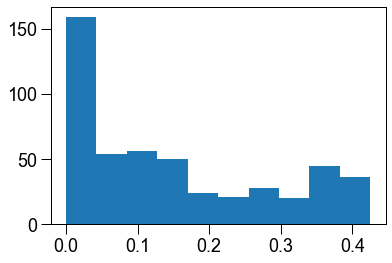

In [52]:
plt.hist(delmus, bins=10);

In [51]:
np.mean(delmus)

0.14927128134979423

### Bootstrapping all parameters

In [ ]:
# gammas are in (g s)/(mol) units.
del_gamma_cat_inv = 3.
del_gamma_resp_inv = 3.
del_gamma_ana_inv = 3.

del_S4 = 2.
del_S3 = 2.
del_S5 = 2.

# KM is in uM
del_KM = 2.
del_r1 = 1.
del_r2 = 1.

In [ ]:
import signal

# Function to handle the alarm signal
def handler(signum, frame):
    raise TimeoutError()

# Set the signal handler
signal.signal(signal.SIGALRM, handler)

BOOT = 500
delmus = []

for _ in tqdm(range(BOOT)):
    mus = []
    zcs = []

    phi_ana = 1-phi_cat-phi_resp
    gamma_cat_inv, gamma_resp_inv, gamma_ana_inv, S4, S3, S5, KM, r1, r2 = sample_params()
    y0 = np.array(give_initial_condns(NADH0, ATP0, KM))

    erred = 0
    for S6 in np.linspace(-0.1, 0.5, 100):
        if erred:
            break
        NUM_METS = len(y0)

        # Evaluation time
        TFINAL = 1e2
        t = np.logspace(-4, 2, 1000 )

        try:
            # Set an alarm for some number of seconds in the future
            signal.alarm(10)  # 10 seconds, adjust this as needed

            y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau', max_step=1.0 ).y
            nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

            # If we've gotten this far without an exception, cancel the alarm
            signal.alarm(0)

            mus.append(nus[-1, -1])
            zcs.append(S6)
        except TimeoutError:
            print(f"Timeout occurred while solving the model for S3={S3}, S4={S4}, S5={S5}")
            erred=1
            continue
        except Exception as e:
            print(f"An error occurred while solving the model for S3={S3}, S4={S4}, S5={S5}: {e}")
            continue

    if len(mus) > 1:
        delmus.append(mus[-1] - mus[0])


  6%|▌         | 6/100 [00:30<09:37,  6.14s/it]

Timeout occurred while solving the model for S3=0.2697249507821981, S4=9.477123247941798, S5=4.340737249022491


 24%|██▍       | 24/100 [01:49<07:34,  5.98s/it]

Timeout occurred while solving the model for S3=0.8553926291222694, S4=3.1672764372681503, S5=4.845866701321666


 84%|████████▍ | 84/100 [06:14<01:39,  6.24s/it]

Timeout occurred while solving the model for S3=0.5413690364258008, S4=15.099529557771824, S5=3.5106582563001107


100%|██████████| 100/100 [07:19<00:00,  4.40s/it]


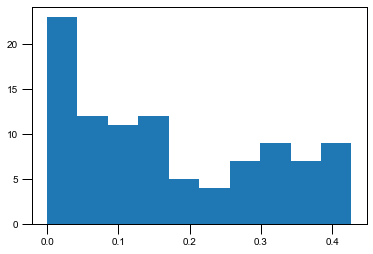

In [ ]:
plt.hist(delmus, bins=10);

In [ ]:
np.mean(delmus)

0.17093336102219475